## Introducción

Entrenamiento de modelo preentrenado para resolver el problema de predecir el ángulo del auto en base a la imagen.

Fuertemente basado en:
- https://towardsdatascience.com/a-practical-example-in-transfer-learning-with-pytorch-846bb835f2db
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchmetrics import MetricCollection, Accuracy, Precision, Recall, F1, ConfusionMatrix
import pandas as pd
import sklearn
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

import importlib
import training_helper
from dataset_modules.one_part_dataset import OnePartDataset
import metrics_helper

importlib.reload(training_helper)
importlib.reload(metrics_helper)

<module 'metrics_helper' from '/clusteruy/home/franco.cuevas/tesis-jupyters-2/metrics_helper.py'>

## Variables

In [30]:
MODEL_NAME = "one_part_model"
EXPERIMENT_NAME = "resnet50_paragolpe_fine_tuning-augment-exp5"
FEATURE_EXTRACTION = False
parte = "Paragolpe Delantero"

device_string = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_string)

if device_string == "cuda":
    print("Usando GPU!")

os.makedirs("./trained_models/{}/{}/".format(MODEL_NAME, EXPERIMENT_NAME), exist_ok=True)

Usando GPU!


## Dataset

Se crea un dataset de tipo `ImageFolder` que se toma de la carpeta `dataset`, donde cada subcarpeta es una de las categorías a entrenar. 

Automáticamente mapea categorías a números `dataset.class_to_idx`.

Finalmente se hace el split en train y test en 80/20.

In [31]:
print("Train!")
train_dataset = OnePartDataset(
    parte,
    transform=transforms.Compose([
        #transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        #transforms.RandomApply([transforms.RandomRotation((-20, 20))], p=0.2),
        transforms.RandomEqualize(),
        #transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    preload=True, # usar True en cluster
    #visibility_file="./dataset_modules/analisis_manual_paragolpe.csv",
    state_file="./dataset_modules/state-train.json"
)

print("Test!")
test_dataset = OnePartDataset(
    parte,
    transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    preload=True, # usar True en cluster
    #visibility_file="./dataset_modules/analisis_manual_paragolpe.csv",
    state_file="./dataset_modules/state-test.json"
)

classes = train_dataset.classes

dataset_sizes = {
    'train': len(train_dataset),
    'test': len(test_dataset)
}

print("#TRAIN {} #TEST {}".format(dataset_sizes["train"], dataset_sizes["test"]))

Train!
----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #720, 54.05%
Class: paragolpe_delantero_roto, #334, 25.08%
Class: paragolpe_delantero_sano, #278, 20.87%
Test!
----- CLASS DISTRIBUTION -----
Class: no_paragolpe_delantero, #196, 58.86%
Class: paragolpe_delantero_roto, #73, 21.92%
Class: paragolpe_delantero_sano, #64, 19.22%
#TRAIN 1332 #TEST 333


## Loaders
Luego, se crean loaders para cada uno de los conjuntos. Los loaders permiten procesar los datos de a batches.

In [32]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0
)

dataloaders = {
    'train': train_loader,
    'test': test_loader
}

## Entrenamiento

En este step se carga el modelo pre-entrenado. Para este ejemplo se utiliza el modelo alexnet por su simplicidad.

#### ¿Finetuning o Feature extraction?

- **Finetuning:** Consiste en incializar la red con los pesos pre-entrenados, y re-entrenar toda la red (ajustar los parámetros de todas las capas) con el dataset custom.
- **Feature extraction:** La diferencia con lo anterior es que se congelan las capas convolucionales, de modo que el entrenamiento no las cambie con nuestros datos.

En ambos casos pisamos la capa de **clasificador** por una capa nueva con 8 categorías, porque el modelo pre-entrenado tiene 1000 labels.

In [33]:
model = models.resnet50(pretrained=True)
NUM_CLASSES = len(classes)

if FEATURE_EXTRACTION:
    for param in model.parameters():
        param.requires_grad = False

model.fc = torch.nn.Linear(2048, NUM_CLASSES)
model = model.to(device)

# Tensorboard metrics writer
writer = SummaryWriter(log_dir='./trained_models/{}/tensorboard/{}'.format(MODEL_NAME, EXPERIMENT_NAME + '-' + datetime.now().strftime("%Y%m%d-%H%M%S")))

# Función de error
criterion = F.cross_entropy

# Optimizador
parameters_to_update = model.parameters()

if FEATURE_EXTRACTION:
    parameters_to_update = model.fc.parameters()

optimizer = optim.SGD(parameters_to_update, lr=0.001)

In [34]:
model = training_helper.train_model(
    model, 
    criterion, 
    optimizer, 
    dataloaders, 
    dataset_sizes, 
    device, 
    writer, 
    NUM_CLASSES,
    'trained_models/{}/{}'.format(MODEL_NAME, EXPERIMENT_NAME),
    main_metric='macro_f1', 
    num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.9645 Main metric (macro_f1): 0.3356 Time: 9.65s
------------------------- GENERAL METRICS -------------------------

Loss 0.9644561690969152
Micro Accuracy 0.5262762904167175
Macro Accuracy 0.33557504415512085
Macro Precision 0.31886085867881775
Macro Recall 0.33557504415512085
Macro F1 0.33557504415512085

test Loss: 0.8512 Main metric (macro_f1): 0.4762 Time: 1.05s
------------------------- GENERAL METRICS -------------------------

Loss 0.8512461228413625
Micro Accuracy 0.672672688961029
Macro Accuracy 0.476157009601593
Macro Precision 0.5793768167495728
Macro Recall 0.476157009601593
Macro F1 0.476157009601593


Epoch 1/24
----------
train Loss: 0.8243 Main metric (macro_f1): 0.4401 Time: 9.55s
------------------------- GENERAL METRICS -------------------------

Loss 0.8243171989738762
Micro Accuracy 0.6186186075210571
Macro Accuracy 0.44013816118240356
Macro Precision 0.5983489751815796
Macro Recall 0.44013816118240356
Macro F1 0.440138161182403

In [35]:
BEST_MODEL_PATH = './trained_models/{}/{}/best_model.pth'.format(MODEL_NAME, EXPERIMENT_NAME)
os.makedirs(os.path.dirname(BEST_MODEL_PATH), exist_ok=True)
torch.save(model.state_dict(), BEST_MODEL_PATH)

## Evaluación final

In [36]:
from dataset_modules.common import pil_loader
model.load_state_dict(torch.load(BEST_MODEL_PATH))
model.eval()

metrics = metrics_helper.init_metrics(device, NUM_CLASSES)
tensorboard_transforms = transforms.Compose([
    transforms.ToTensor()
])

total_loss = 0.0

for i, (images, labels, imgs_path) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        metrics(outputs, labels)
        
        predictions = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, labels)
        
        total_loss += loss.item() * images.size(0)
        
        for sampleno in range(images.shape[0]):
            if(labels[sampleno] != predictions[sampleno]):
                name = 'Misclasified_Predicted-{}_Classified-{}/{}'.format(classes[predictions[sampleno]], classes[labels[sampleno]], imgs_path[sampleno])
                
                writer.add_image(name, tensorboard_transforms(pil_loader('./dataset_modules/imgs/' + imgs_path[sampleno])))
                writer.flush()
        
total_loss /= dataset_sizes["test"]

metrics_result = metrics.compute()

In [37]:
macro_metrics = metrics_helper.generate_macro_metrics(metrics_result, total_loss)
per_class_metrics = metrics_helper.generate_per_class_metrics(metrics_result, classes)

macro_metrics.to_csv('./trained_models/{}/{}/best_model_macro_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)
per_class_metrics.to_csv('./trained_models/{}/{}/best_model_per_class_metrics.csv'.format(MODEL_NAME, EXPERIMENT_NAME), index=False)

------------------------- GENERAL METRICS -------------------------

Loss 0.34251849433860265
Micro Accuracy 0.8498498201370239
Macro Accuracy 0.7798929810523987
Macro Precision 0.7745113372802734
Macro Recall 0.7798929810523987
Macro F1 0.7798929810523987

------------------------- PER CLASS METRICS -------------------------


,class,accuracy,precision,recall,f1
0,paragolpe_delantero_roto,0.589041,0.716667,0.589041,0.589041
1,paragolpe_delantero_sano,0.781250,0.617284,0.781250,0.781250
2,no_paragolpe_delantero,0.969388,0.989583,0.969388,0.969388


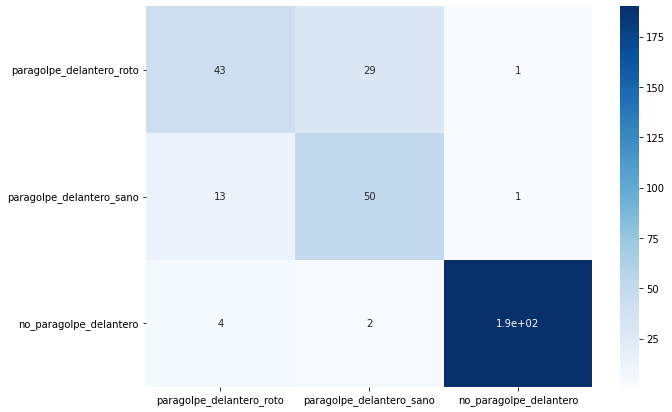

In [38]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(metrics_result['confusion_matrix'], index = classes,
                  columns = classes)

df_cm = df_cm.applymap(lambda x: x.item())

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="Blues")
df_cm.to_csv('./trained_models/{}/{}/confusion_matrix.csv'.format(MODEL_NAME, EXPERIMENT_NAME))